# ANALYSING CIC 2017 DATASET AND SELECTING BEST FEATURES FOR SLOWLORIS ATTACK


## Index
    1. Data Preparation
    2. Data Split
    3. Feature Selection
    4. PCA

In [1]:
import os
import subprocess
import seaborn as sns  
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from __future__ import print_function
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
def get_data():
    if os.path.exists("slowhttptest_filtered.csv"):
        print("-- slowhttptest.csv found locally")
    df = pd.read_csv("slowhttptest_filtered.csv", index_col=False)
    return df

In [3]:
def encode_target(df, target_column):
    df_mod = df.copy()
    targets = df_mod[target_column].unique()
    map_to_int = {name: n for n, name in enumerate(targets)}
    df_mod["Target"] = df_mod[target_column].replace(map_to_int)
    return (df_mod, targets)

In [4]:
data = get_data()

-- slowhttptest.csv found locally


# 1.0 Data processing

### We initially drop variables that won't contribute to knowlege of slowloris attack because they change from instance to instance

In [5]:
columns = ['Flow ID', ' Source IP', ' Source Port', ' Destination IP', ' Destination Port', ' Protocol', ' Timestamp',]
data.drop(columns, inplace=True, axis=1)
print(data.keys())
print(data.shape[0])
print(data.shape[1])

Index([u' Flow Duration', u' Total Fwd Packets', u' Total Backward Packets',
       u'Total Length of Fwd Packets', u' Total Length of Bwd Packets',
       u' Fwd Packet Length Max', u' Fwd Packet Length Min',
       u' Fwd Packet Length Mean', u' Fwd Packet Length Std',
       u'Bwd Packet Length Max', u' Bwd Packet Length Min',
       u' Bwd Packet Length Mean', u' Bwd Packet Length Std', u'Flow Bytes/s',
       u' Flow Packets/s', u' Flow IAT Mean', u' Flow IAT Std',
       u' Flow IAT Max', u' Flow IAT Min', u'Fwd IAT Total', u' Fwd IAT Mean',
       u' Fwd IAT Std', u' Fwd IAT Max', u' Fwd IAT Min', u'Bwd IAT Total',
       u' Bwd IAT Mean', u' Bwd IAT Std', u' Bwd IAT Max', u' Bwd IAT Min',
       u'Fwd PSH Flags', u' Bwd PSH Flags', u' Fwd URG Flags',
       u' Bwd URG Flags', u' Fwd Header Length', u' Bwd Header Length',
       u'Fwd Packets/s', u' Bwd Packets/s', u' Min Packet Length',
       u' Max Packet Length', u' Packet Length Mean', u' Packet Length Std',
       u' Packe

### We also need to convert lables into numeric values for classification

In [6]:
df2, targets = encode_target(data, " Label")



### We drop any rows that contain NaN

In [7]:
df2 = df2.dropna(axis=0, how='any')
df2.isnull().sum().sum()

0

### We also drop columns that have 0 variance

In [8]:
list_unq = (df2.apply(pd.Series.nunique) != 1)
list_unq[list_unq == 0]

 Bwd PSH Flags           False
 Fwd URG Flags           False
 Bwd URG Flags           False
 CWE Flag Count          False
Fwd Avg Bytes/Bulk       False
 Fwd Avg Packets/Bulk    False
 Fwd Avg Bulk Rate       False
 Bwd Avg Bytes/Bulk      False
 Bwd Avg Packets/Bulk    False
Bwd Avg Bulk Rate        False
dtype: bool

In [9]:
df2 = df2.loc[:, df2.apply(pd.Series.nunique) != 1]

# 2.0 Data split
## We split data in features, lables

In [10]:
features = list(df2.columns[:-2])
y = df2["Target"]
X = df2[features]

In [11]:
X

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
0,166,2,1,12,6,6,6,6.000000,0.000000,6,...,1,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,139,2,0,12,0,6,6,6.000000,0.000000,0,...,1,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,124,2,0,12,0,6,6,6.000000,0.000000,0,...,1,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2126800,9,7,2666,2045,1070,0,296.222222,458.509209,959,...,4,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3,2,0,31,0,31,0,15.500000,21.920310,0,...,0,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,237921,4,5,298,1769,210,0,74.500000,99.403219,1769,...,2,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1098,3,0,0,0,0,0,0.000000,0.000000,0,...,0,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0,1,1,6,6,6,6,6.000000,0.000000,6,...,0,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1150593,20,22,790,30449,357,0,39.500000,97.825570,4272,...,5,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,1812,2,0,37,0,37,0,18.500000,26.162951,0,...,0,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


0    27077
1     5371
Name: Target, dtype: int64

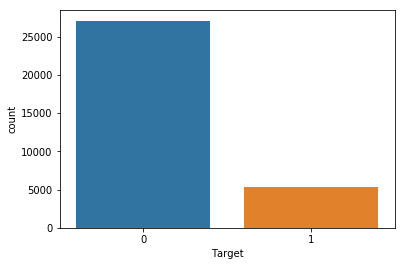

In [12]:
graph = sns.countplot(y ,label="Count")
df2["Target"].value_counts()


In [13]:
value_fig = graph.get_figure()
value_fig.savefig("slowhttptest_data.png")

### df2 is original data frame with neccesary processing done. From now on we make variants of data frame X and Y








# 3.0 Feature Selection


### Index
     3.1 1 Correlation
     3.2 K best features
     3.3 Recursive feature elimination with random forest
     3.4 Recursice feature elimination with cross validation and random forest
     3.5 Tree based feature selection

## 3.1 High Correlation



In [14]:
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


In [15]:
upper

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
Flow Duration,NaN,0.209728,0.138239,0.118796,0.076290,0.204324,0.102473,0.016880,0.157741,0.244307,...,0.143240,0.224046,0.462429,0.252502,0.505511,0.412589,0.731727,0.449726,0.784152,0.668119
Total Fwd Packets,NaN,NaN,0.962334,0.261811,0.946142,0.168792,0.036721,0.045001,0.098077,0.395971,...,0.941912,0.032571,0.090784,0.169102,0.148245,0.049141,0.067268,0.051090,0.074257,0.058843
Total Backward Packets,NaN,NaN,NaN,0.245706,0.972316,0.154446,0.022667,0.037714,0.081125,0.379226,...,0.937177,0.053379,0.013866,0.103308,0.056852,0.010829,0.044645,0.009850,0.039780,0.046123
Total Length of Fwd Packets,NaN,NaN,NaN,NaN,0.139637,0.376837,0.004248,0.275713,0.306279,0.175541,...,0.292067,0.025483,0.120918,0.308449,0.202214,0.039859,0.009401,0.005126,0.011768,0.008404
Total Length of Bwd Packets,NaN,NaN,NaN,NaN,NaN,0.083864,0.013776,0.007654,0.030007,0.321642,...,0.904984,0.035717,0.009711,0.051908,0.031402,0.002083,0.025633,0.006722,0.022425,0.026582
Fwd Packet Length Max,NaN,NaN,NaN,NaN,NaN,NaN,0.171275,0.755044,0.910505,0.376474,...,0.150833,0.005743,0.053300,0.132758,0.014366,0.088804,0.088903,0.071038,0.071606,0.100749
Fwd Packet Length Min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.661303,0.077326,0.064048,...,0.025113,0.040875,0.074030,0.024578,0.074267,0.070389,0.064832,0.067241,0.074862,0.054637
Fwd Packet Length Mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.665415,0.118469,...,0.052944,0.047982,0.063061,0.125400,0.012497,0.101398,0.000045,0.068126,0.009494,0.011423
Fwd Packet Length Std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.280416,...,0.088256,0.018338,0.041177,0.124409,0.016671,0.075632,0.095615,0.061808,0.080552,0.106517
Bwd Packet Length Max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.336719,0.107886,0.087664,0.083463,0.022433,0.106567,0.034525,0.094766,0.011850,0.047969


In [16]:
to_drop = [column for column in upper.columns if any(upper[column] == 1.0)]
print(len(to_drop))
print(to_drop)

9
[' SYN Flag Count', ' ECE Flag Count', ' Avg Fwd Segment Size', ' Avg Bwd Segment Size', ' Fwd Header Length.1', 'Subflow Fwd Packets', ' Subflow Fwd Bytes', ' Subflow Bwd Packets', ' Subflow Bwd Bytes']


### 3.1.2 To get an idea who all were correalted perfectly i.e 1.0

In [17]:
corrMatrix = X.corr()
corrMatrix.loc[:,:] =  np.tril(corr_matrix, k=-1)

already_in = set()
result_1 = []
for col in corrMatrix:
    perfect_corr = corrMatrix[col][corrMatrix[col] == 1].index.tolist()
    if perfect_corr and col not in already_in:
        already_in.update(set(perfect_corr))
        perfect_corr.append(col)
        result_1.append(perfect_corr)

In [18]:
for element in result_1:
    print(element)

['Subflow Fwd Packets', ' Total Fwd Packets']
[' Subflow Bwd Packets', ' Total Backward Packets']
[' Subflow Fwd Bytes', 'Total Length of Fwd Packets']
[' Subflow Bwd Bytes', ' Total Length of Bwd Packets']
[' Avg Fwd Segment Size', ' Fwd Packet Length Mean']
[' Avg Bwd Segment Size', ' Bwd Packet Length Mean']
[' SYN Flag Count', 'Fwd PSH Flags']
[' Fwd Header Length.1', ' Fwd Header Length']
[' ECE Flag Count', ' RST Flag Count']


### 3.1.4 Dropping features with 1 correlation

In [19]:
X_new = X.drop(X[to_drop], axis=1)

In [20]:
X_new.head()

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
0,166,2,1,12,6,6,6,6.000000,0.000000,6,...,1,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,139,2,0,12,0,6,6,6.000000,0.000000,0,...,1,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,124,2,0,12,0,6,6,6.000000,0.000000,0,...,1,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2126800,9,7,2666,2045,1070,0,296.222222,458.509209,959,...,4,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3,2,0,31,0,31,0,15.500000,21.920310,0,...,0,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
X_new.isnull().sum().sum()

0

In [22]:
def fix_data_frame(x_train):
    col = x_train.columns[x_train.dtypes.eq(object)]
    x_train[col] = x_train[col].apply(pd.to_numeric, errors='coerce', axis=1)
    return np.nan_to_num(x_train)

In [23]:
def generate_data(x, y, split, seed):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=split, random_state=seed)
    x_train = fix_data_frame(x_train)
    x_test = fix_data_frame(x_test)
    return x_train, x_test, y_train, y_test

In [24]:
def ranking(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x,2), ranks)
    return dict(zip(names, ranks))

In [25]:
x_train, x_test, y_train, y_test = generate_data(X_new, y, 0.3, 21)
ranks = {}
y_train.value_counts()

/home/chromares/.local/lib/python2.7/site-packages/pandas/core/frame.py:2440: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


0    18963
1     3750
Name: Target, dtype: int64

## 3.0 K-best

In [26]:
select_feature_5 = SelectKBest(f_classif, k=5).fit(x_train, y_train.values)

/home/chromares/.local/lib/python2.7/site-packages/sklearn/utils/__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


In [27]:
scores = select_feature_5.scores_
scores  = [float(i) for i in scores]
features = X_new.columns
    
k_best_f_classif = zip(scores, features)

k_best_f_classif.sort(key= lambda x : x[0], reverse=True)
#for element in k_best_f_classif:
#    print(element[1].lstrip())

ranks["K-Best"] = ranking(scores, X_new.columns)

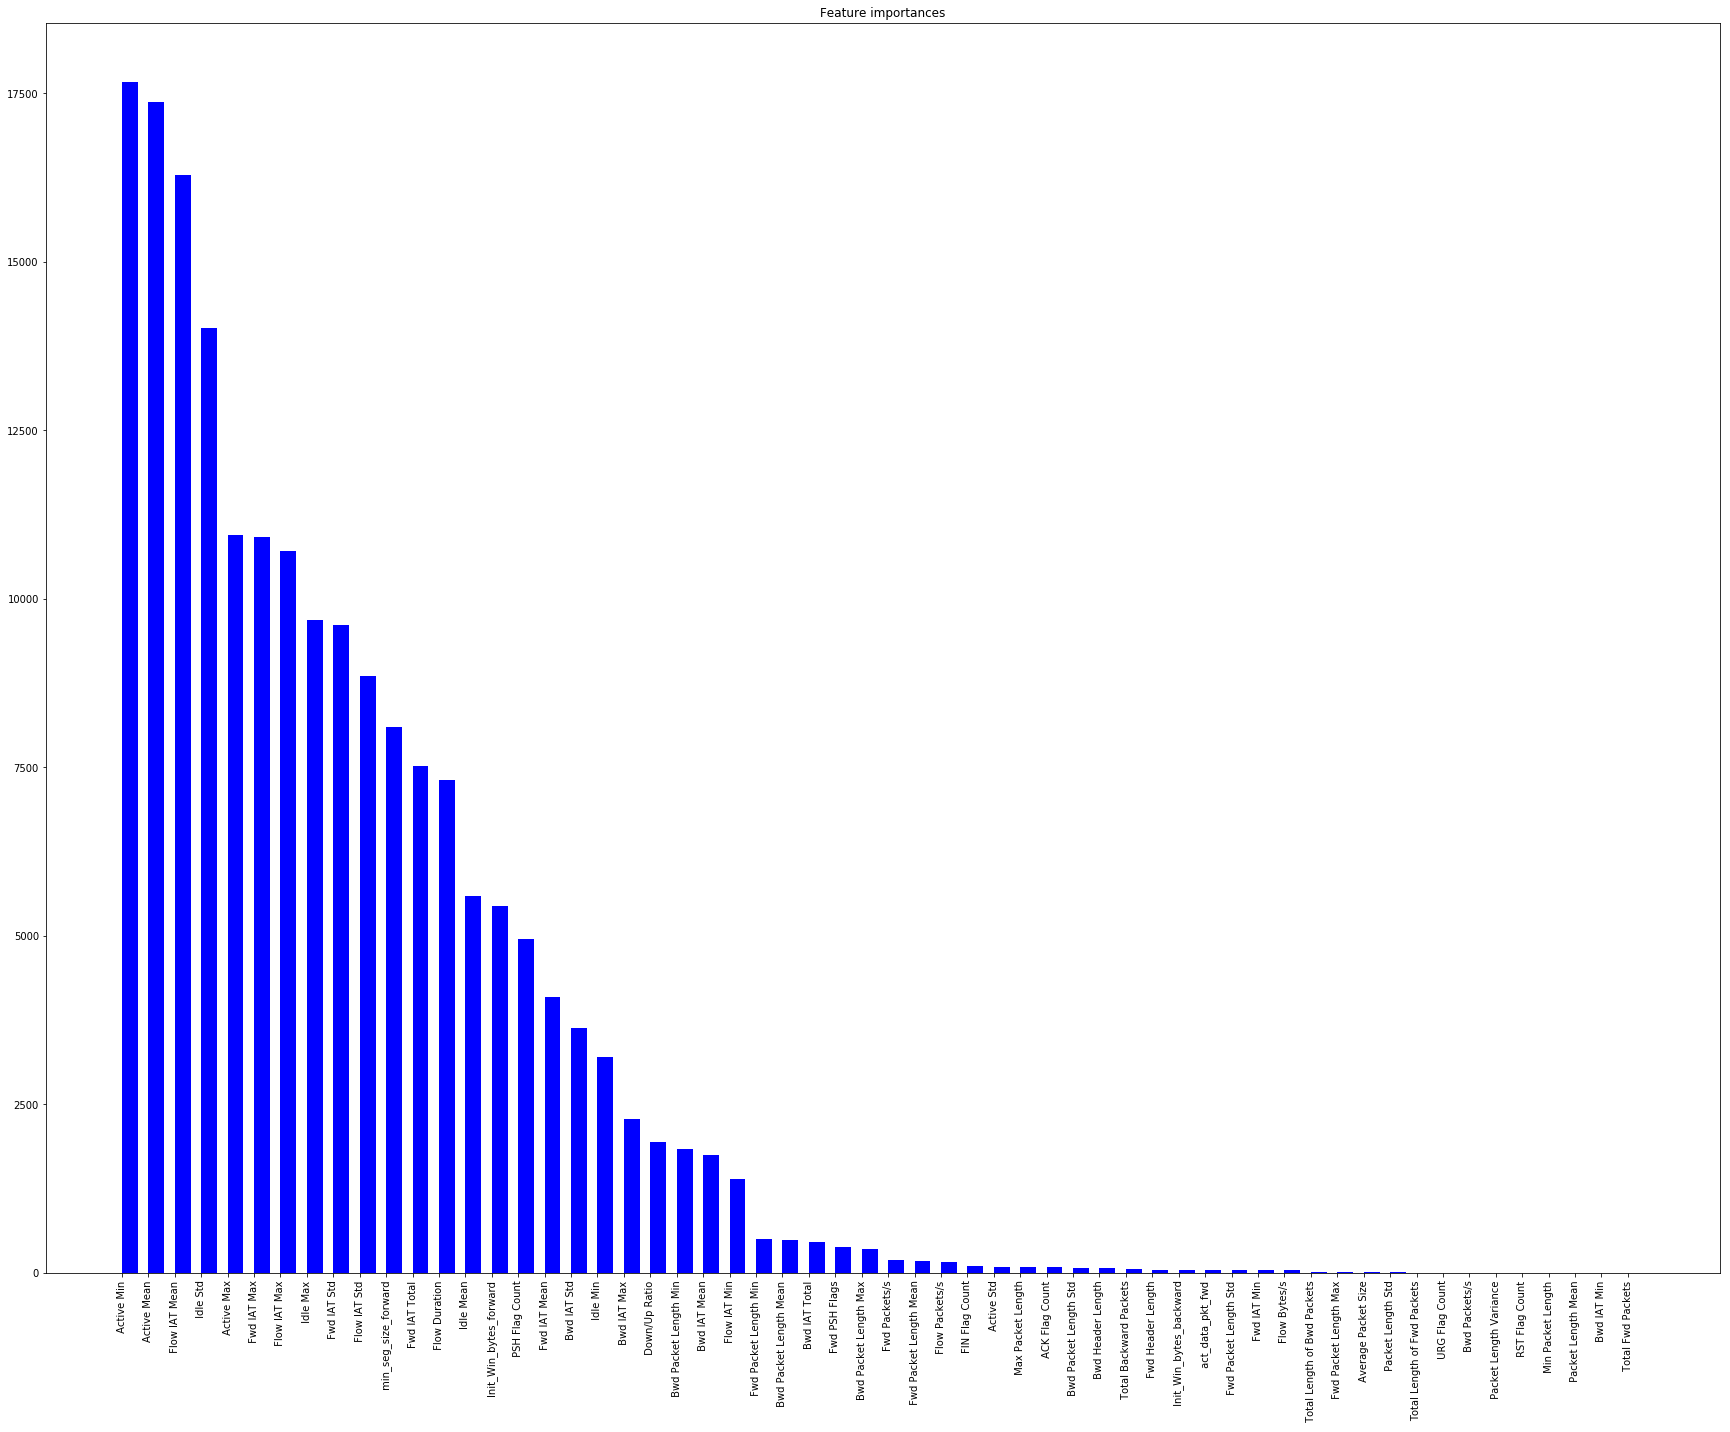

In [28]:
k_x = [x[1] for x in k_best_f_classif]
k_y = [x[0] for x in k_best_f_classif]
plt.figure(1, figsize=(30, 23))
plt.title("Feature importances")
plt.bar(range(x_train.shape[1]), k_y, 0.6,
       color="b", align="edge")
plt.xticks(range(x_train.shape[1]), k_x,rotation=90)
plt.savefig("slowtest_kbest.png")

## 3.2 Recursive Feature Elimination using Random Forest

In [25]:
hyper_optimal = {}


In [26]:
from sklearn.grid_search import GridSearchCV
def evaluate_param(parameter, num_range, index):
    grid_search = GridSearchCV(clf, param_grid = {parameter: num_range})
    grid_search.fit(x_train, y_train.values)
    
    df = {}
    for i, score in enumerate(grid_search.grid_scores_):
        df[score[0][parameter]] = score[1]
       
    df = pd.DataFrame.from_dict(df, orient='index')
    df.reset_index(level=0, inplace=True)
    df = df.sort_values(by='index')
 
    plt.subplot(3,2,index)
    plot = plt.plot(df['index'], df[0])
    plt.title(parameter)
    print("adding parameter ", parameter)
    optimum = df.sort_values([0, 'index'], ascending=[0, 1])[:3]
    val = optimum['index']
    hyper_optimal[parameter] = val
    
    return plot, df

/home/chromares/.local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/chromares/.local/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [38]:
param_grid_ext = {"n_estimators": np.arange(100, 500, 2),
                "max_depth": np.arange(1, 30, 2),
                "min_samples_split": np.arange(2, 150, 2),
                "min_samples_leaf": np.arange(1, 100, 2),
                "max_leaf_nodes": np.arange(2, 50, 2),
                "min_weight_fraction_leaf": np.arange(0.1, 0.8, 0.1)
             }

In [ ]:
param_grid_ext

{'max_depth': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]),
 'max_leaf_nodes': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34,
        36, 38, 40, 42, 44, 46, 48]),
 'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
        35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67,
        69, 71, 73, 75, 77, 79, 81, 83, 85, 87, 89, 91, 93, 95, 97, 99]),
 'min_samples_split': array([  2,   4,   6,   8,  10,  12,  14,  16,  18,  20,  22,  24,  26,
         28,  30,  32,  34,  36,  38,  40,  42,  44,  46,  48,  50,  52,
         54,  56,  58,  60,  62,  64,  66,  68,  70,  72,  74,  76,  78,
         80,  82,  84,  86,  88,  90,  92,  94,  96,  98, 100, 102, 104,
        106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130,
        132, 134, 136, 138, 140, 142, 144, 146, 148]),
 'min_weight_fraction_leaf': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]),
 'n_estimators': array([1

In [ ]:
clf = RandomForestClassifier(n_jobs=-1, random_state = 74)
index = 1
this_is_that = plt.figure(figsize=(32,24))
for parameter, param_range in dict.items(param_grid_ext):
    evaluate_param(parameter, param_range, index)
    index += 1

In [ ]:
this_is_that.savefig("slowtest_rf_tuning.png")

In [ ]:
param_dict = {}
for key in hyper_optimal.keys():
    param_dict[key] = hyper_optimal[key].tolist()

print(param_dict)

In [ ]:
grid_search = GridSearchCV(clf, param_grid=param_dict, verbose=1)
grid_search.fit(x_train, y_train.values)


In [ ]:
from operator import itemgetter
optimal_parameters = sorted(grid_search.grid_scores_, key=itemgetter(1), reverse=True)[:5][0][0]
optimal_parameters

In [ ]:
optimal_parameters

In [35]:
random_forest = RandomForestClassifier(n_jobs=-1, random_state=74,
                                       min_samples_leaf=1,
                                       min_samples_split=2,
                                       min_weight_fraction_leaf=0.1,
                                       max_leaf_nodes=9,
                                       max_depth=5,
                                       n_estimators=22)

In [36]:
#random_forest = RandomForestClassifier(n_jobs=-1, random_state=74,
#                                       min_samples_leaf=optimal_parameters['min_samples_leaf'],
#                                       min_samples_split=optimal_parameters['min_samples_split'],
#                                       min_weight_fraction_leaf=optimal_parameters['min_weight_fraction_leaf'],
#                                       max_leaf_nodes=optimal_parameters['max_leaf_nodes'],
#                                       max_depth=optimal_parameters['max_depth'],
#                                       n_estimators=optimal_parameters['n_estimators'])

In [37]:
rfe = RFE(estimator=random_forest, n_features_to_select=1)
rfe.fit(x_train, y_train)

RFE(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=9,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.1, n_estimators=22, n_jobs=-1,
            oob_score=False, random_state=74, verbose=0, warm_start=False),
  n_features_to_select=1, step=1, verbose=0)

In [38]:
scores = rfe.ranking_
scores  = [i for i in scores]
    
rfe_rankings_kk = zip(scores, features)

rfe_rankings_kk.sort(key= lambda x : x[0])
#for element in rfe_rankings_kk:
#    print(element)

In [39]:
ranks["RFE"] = ranking(list(map(float, rfe.ranking_)), X_new.columns, order=-1)

In [40]:
ranks

{'K-Best': {' ACK Flag Count': 0.0,
  ' Active Max': 0.62,
  ' Active Min': 1.0,
  ' Active Std': 0.01,
  ' Average Packet Size': 0.0,
  ' Bwd Header Length': 0.0,
  ' Bwd IAT Max': 0.13,
  ' Bwd IAT Mean': 0.1,
  ' Bwd IAT Min': 0.0,
  ' Bwd IAT Std': 0.21,
  ' Bwd Packet Length Mean': 0.03,
  ' Bwd Packet Length Min': 0.1,
  ' Bwd Packet Length Std': 0.0,
  ' Bwd Packets/s': 0.0,
  ' Down/Up Ratio': 0.11,
  ' Flow Duration': 0.41,
  ' Flow IAT Max': 0.61,
  ' Flow IAT Mean': 0.92,
  ' Flow IAT Min': 0.08,
  ' Flow IAT Std': 0.5,
  ' Flow Packets/s': 0.01,
  ' Fwd Header Length': 0.0,
  ' Fwd IAT Max': 0.62,
  ' Fwd IAT Mean': 0.23,
  ' Fwd IAT Min': 0.0,
  ' Fwd IAT Std': 0.54,
  ' Fwd Packet Length Max': 0.0,
  ' Fwd Packet Length Mean': 0.01,
  ' Fwd Packet Length Min': 0.03,
  ' Fwd Packet Length Std': 0.0,
  ' Idle Max': 0.55,
  ' Idle Min': 0.18,
  ' Idle Std': 0.79,
  ' Init_Win_bytes_backward': 0.0,
  ' Max Packet Length': 0.01,
  ' Min Packet Length': 0.0,
  ' PSH Flag Count'

### Tree based feature selecion

In [41]:
x_train.shape

(22713, 58)

In [42]:
random_forest_classifier = random_forest.fit(x_train, y_train.values)

In [43]:
importances = random_forest_classifier.feature_importances_

In [44]:
importances

array([3.27642645e-03, 0.00000000e+00, 1.67208451e-06, 3.91785876e-03,
       3.06431453e-04, 1.49854864e-05, 7.81917038e-04, 1.40711593e-02,
       0.00000000e+00, 9.16661285e-07, 1.74725000e-03, 1.55767492e-02,
       4.85097082e-07, 4.97381454e-07, 1.32822696e-01, 9.97470329e-02,
       4.37587859e-02, 4.07463813e-07, 4.19067556e-09, 4.17635588e-02,
       1.35749298e-01, 2.30258516e-05, 5.65005526e-06, 9.74437102e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 2.95064240e-04, 2.60637214e-03,
       9.81555441e-02, 2.38911727e-02, 1.77866513e-06, 2.95349414e-03,
       0.00000000e+00, 2.37085279e-03, 2.54266955e-03, 0.00000000e+00,
       0.00000000e+00, 3.99397113e-05, 1.09756829e-03, 0.00000000e+00,
       3.14685192e-04, 1.50125924e-02, 1.00986119e-03, 2.47335291e-06,
       0.00000000e+00, 7.41751258e-04, 1.16803015e-01, 0.00000000e+00,
       5.26434245e-02, 0.00000000e+00, 0.00000000e+00, 3.59617275e-02,
      

In [45]:
std = np.std([tree.feature_importances_ for tree in random_forest_classifier.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

print("Feature ranking:")

ranking_tree_based = []
for f in range(x_train.shape[1]):
    print(f + 1, features[indices[f]])
    ranking_tree_based.append(features[indices[f]])

ranking_tree_zip = zip(features[indices], importances[indices])
ranking_tree_zip.sort(key= lambda x : x[1], reverse=True)

for element in ranking_tree_zip:
    print(element[1])
    
ranks["RF"] = ranking(random_forest_classifier.feature_importances_, X_new.columns)

Feature ranking:
1  Fwd IAT Mean
2  Flow Packets/s
3 Active Mean
4  Flow IAT Mean
5 Fwd Packets/s
6  Fwd IAT Min
7  Active Max
8  Flow IAT Std
9 Fwd IAT Total
10  Idle Std
11  Idle Max
12  Idle Min
13  Bwd Packets/s
14  Bwd Packet Length Mean
15  Average Packet Size
16  Fwd Packet Length Mean
17 Total Length of Fwd Packets
18  Flow Duration
19  Max Packet Length
20  Bwd Header Length
21  Packet Length Variance
22  Packet Length Std
23  Bwd Packet Length Min
24  ACK Flag Count
25 Init_Win_bytes_forward
26  Fwd Packet Length Min
27  min_seg_size_forward
28  Down/Up Ratio
29  Total Length of Bwd Packets
30  Fwd Header Length
31  PSH Flag Count
32  Fwd IAT Std
33  Fwd Packet Length Max
34  Fwd IAT Max
35  Init_Win_bytes_backward
36  Min Packet Length
37  Total Backward Packets
38 Bwd Packet Length Max
39 Flow Bytes/s
40  Bwd Packet Length Std
41  Flow IAT Max
42  Flow IAT Min
43  Active Min
44  Fwd Packet Length Std
45  Total Fwd Packets
46 Idle Mean
47 FIN Flag Count
48  Active Std
49  ac

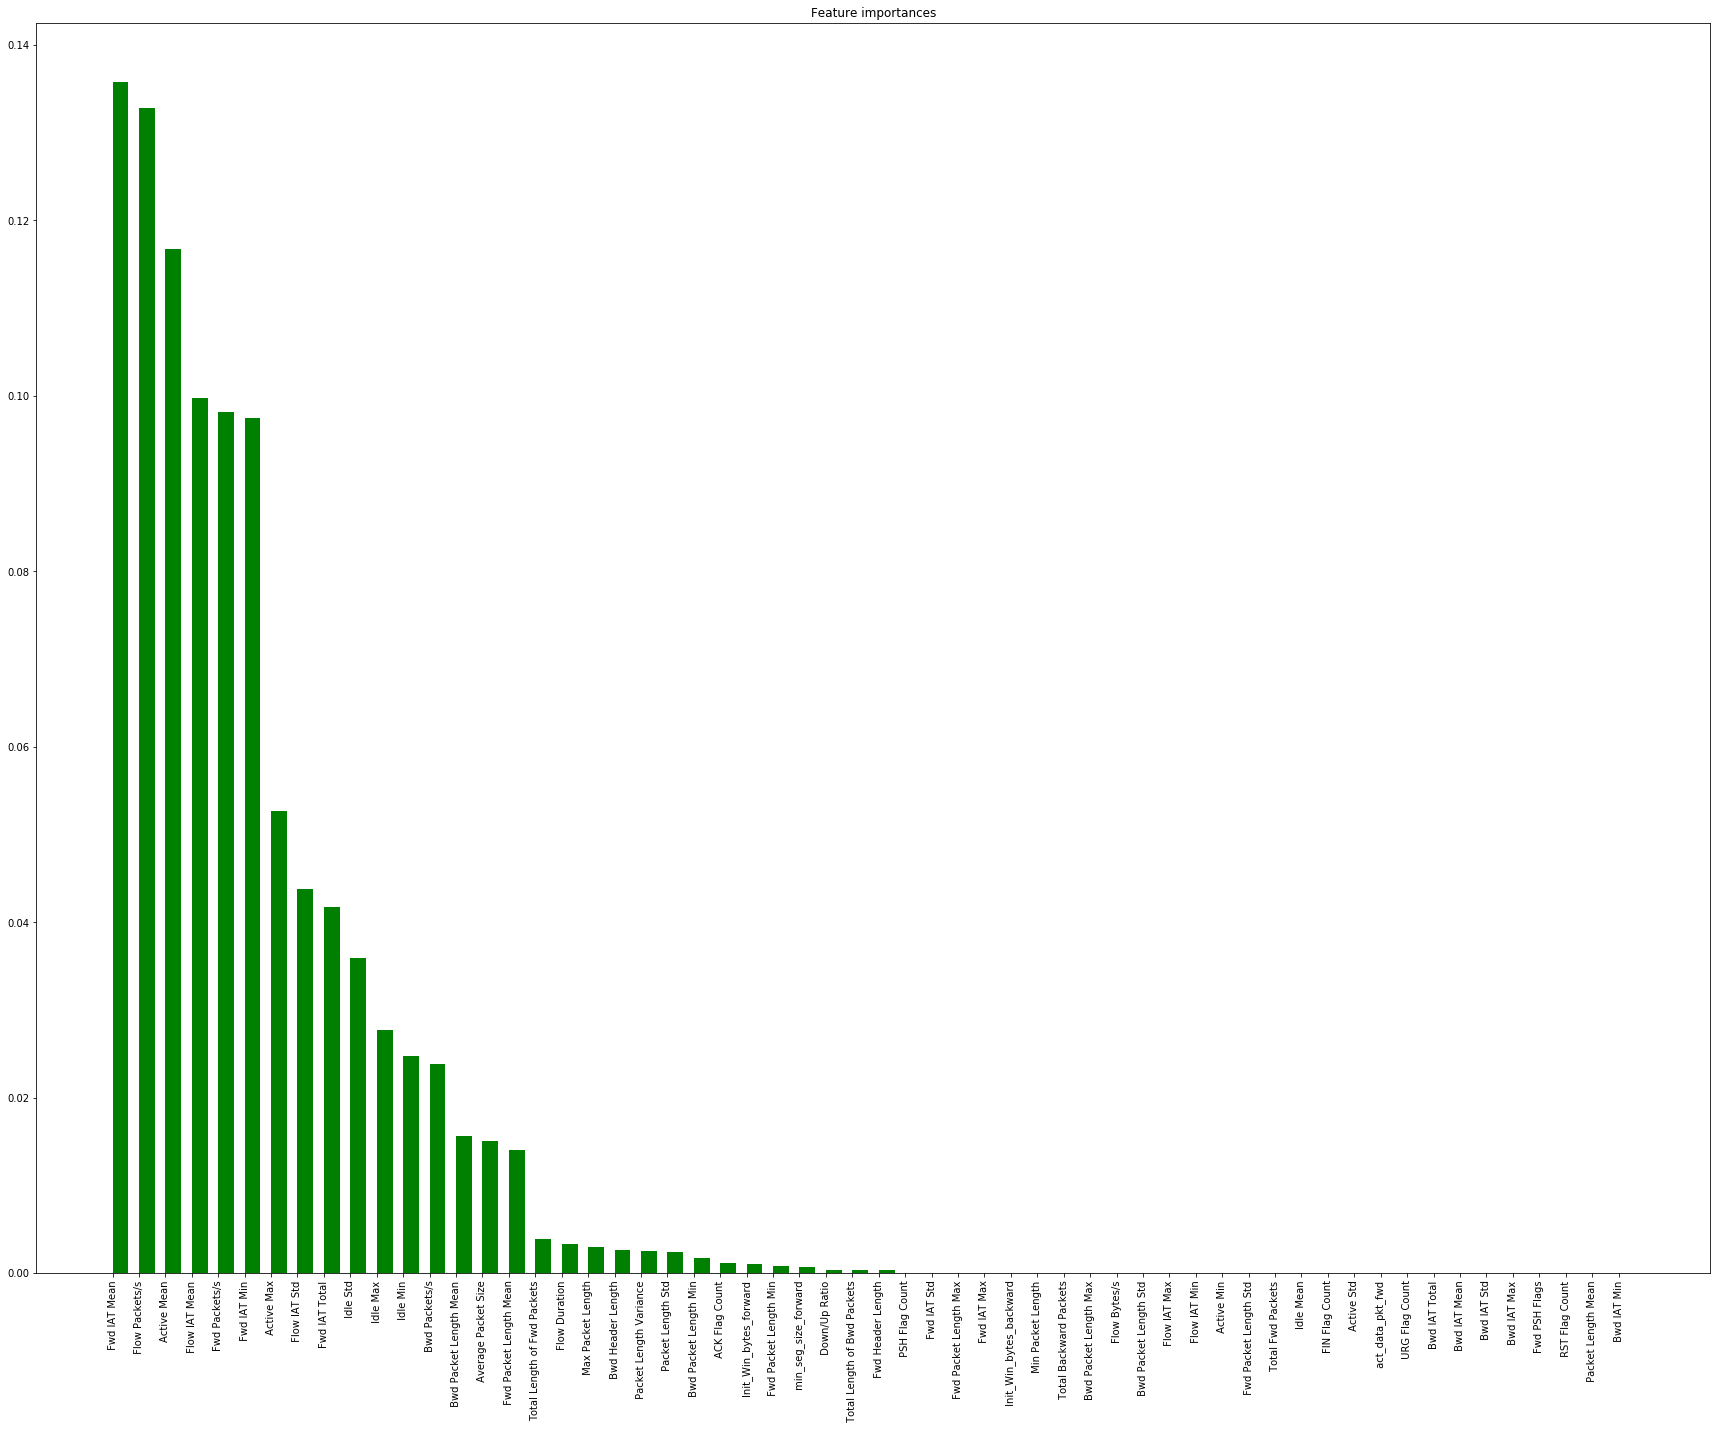

In [46]:
plt.figure(1, figsize=(30, 23))
plt.title("Feature importances")
plt.bar(range(x_train.shape[1]), importances[indices], 0.6,
       color="g", align="edge")
plt.xticks(range(x_train.shape[1]), X_new.columns[indices],rotation=90)
plt.savefig("rf_features_slowtest.png")

## Summary

### 1. Eliminate features with 0 variance
### 2. Eliminate features with 1 correlation
### 3. Estimate feature rankings (various data set sizes) with
        K best
        Recursive feature elimination
        Random Forest

In [47]:
ranks

{'K-Best': {' ACK Flag Count': 0.0,
  ' Active Max': 0.62,
  ' Active Min': 1.0,
  ' Active Std': 0.01,
  ' Average Packet Size': 0.0,
  ' Bwd Header Length': 0.0,
  ' Bwd IAT Max': 0.13,
  ' Bwd IAT Mean': 0.1,
  ' Bwd IAT Min': 0.0,
  ' Bwd IAT Std': 0.21,
  ' Bwd Packet Length Mean': 0.03,
  ' Bwd Packet Length Min': 0.1,
  ' Bwd Packet Length Std': 0.0,
  ' Bwd Packets/s': 0.0,
  ' Down/Up Ratio': 0.11,
  ' Flow Duration': 0.41,
  ' Flow IAT Max': 0.61,
  ' Flow IAT Mean': 0.92,
  ' Flow IAT Min': 0.08,
  ' Flow IAT Std': 0.5,
  ' Flow Packets/s': 0.01,
  ' Fwd Header Length': 0.0,
  ' Fwd IAT Max': 0.62,
  ' Fwd IAT Mean': 0.23,
  ' Fwd IAT Min': 0.0,
  ' Fwd IAT Std': 0.54,
  ' Fwd Packet Length Max': 0.0,
  ' Fwd Packet Length Mean': 0.01,
  ' Fwd Packet Length Min': 0.03,
  ' Fwd Packet Length Std': 0.0,
  ' Idle Max': 0.55,
  ' Idle Min': 0.18,
  ' Idle Std': 0.79,
  ' Init_Win_bytes_backward': 0.0,
  ' Max Packet Length': 0.01,
  ' Min Packet Length': 0.0,
  ' PSH Flag Count'

In [48]:
r = {}
for name in X_new.columns:
    r[name] = round(np.mean([ranks[method][name] 
                             for method in ranks.keys()]), 2)
 
methods = sorted(ranks.keys())
ranks["Mean"] = r
methods.append("Mean")
 
print("\t\t\t\t%s" % "\t".join(methods))
for name in X_new.columns:
    print("%s\t\t\t%s" % (name, "\t".join(map(str, 
                         [ranks[method][name] for method in methods]))))


				K-Best	RF	RFE	Mean
 Flow Duration			0.41	0.02	0.07	0.17
 Total Fwd Packets			0.0	0.0	0.09	0.03
 Total Backward Packets			0.0	0.0	0.12	0.04
Total Length of Fwd Packets			0.0	0.03	0.28	0.1
 Total Length of Bwd Packets			0.0	0.0	0.35	0.12
 Fwd Packet Length Max			0.0	0.0	0.82	0.27
 Fwd Packet Length Min			0.03	0.01	0.58	0.21
 Fwd Packet Length Mean			0.01	0.1	0.79	0.3
 Fwd Packet Length Std			0.0	0.0	0.63	0.21
Bwd Packet Length Max			0.02	0.0	0.67	0.23
 Bwd Packet Length Min			0.1	0.01	0.65	0.25
 Bwd Packet Length Mean			0.03	0.11	0.89	0.34
 Bwd Packet Length Std			0.0	0.0	0.51	0.17
Flow Bytes/s			0.0	0.0	0.61	0.2
 Flow Packets/s			0.01	0.98	0.96	0.65
 Flow IAT Mean			0.92	0.73	0.98	0.88
 Flow IAT Std			0.5	0.32	0.33	0.38
 Flow IAT Max			0.61	0.0	0.68	0.43
 Flow IAT Min			0.08	0.0	0.93	0.34
Fwd IAT Total			0.43	0.31	0.91	0.55
 Fwd IAT Mean			0.23	1.0	1.0	0.74
 Fwd IAT Std			0.54	0.0	0.46	0.33
 Fwd IAT Max			0.62	0.0	0.95	0.52
 Fwd IAT Min			0.0	0.72	0.56	0.43
Bwd IAT Total			0.03	0.0	

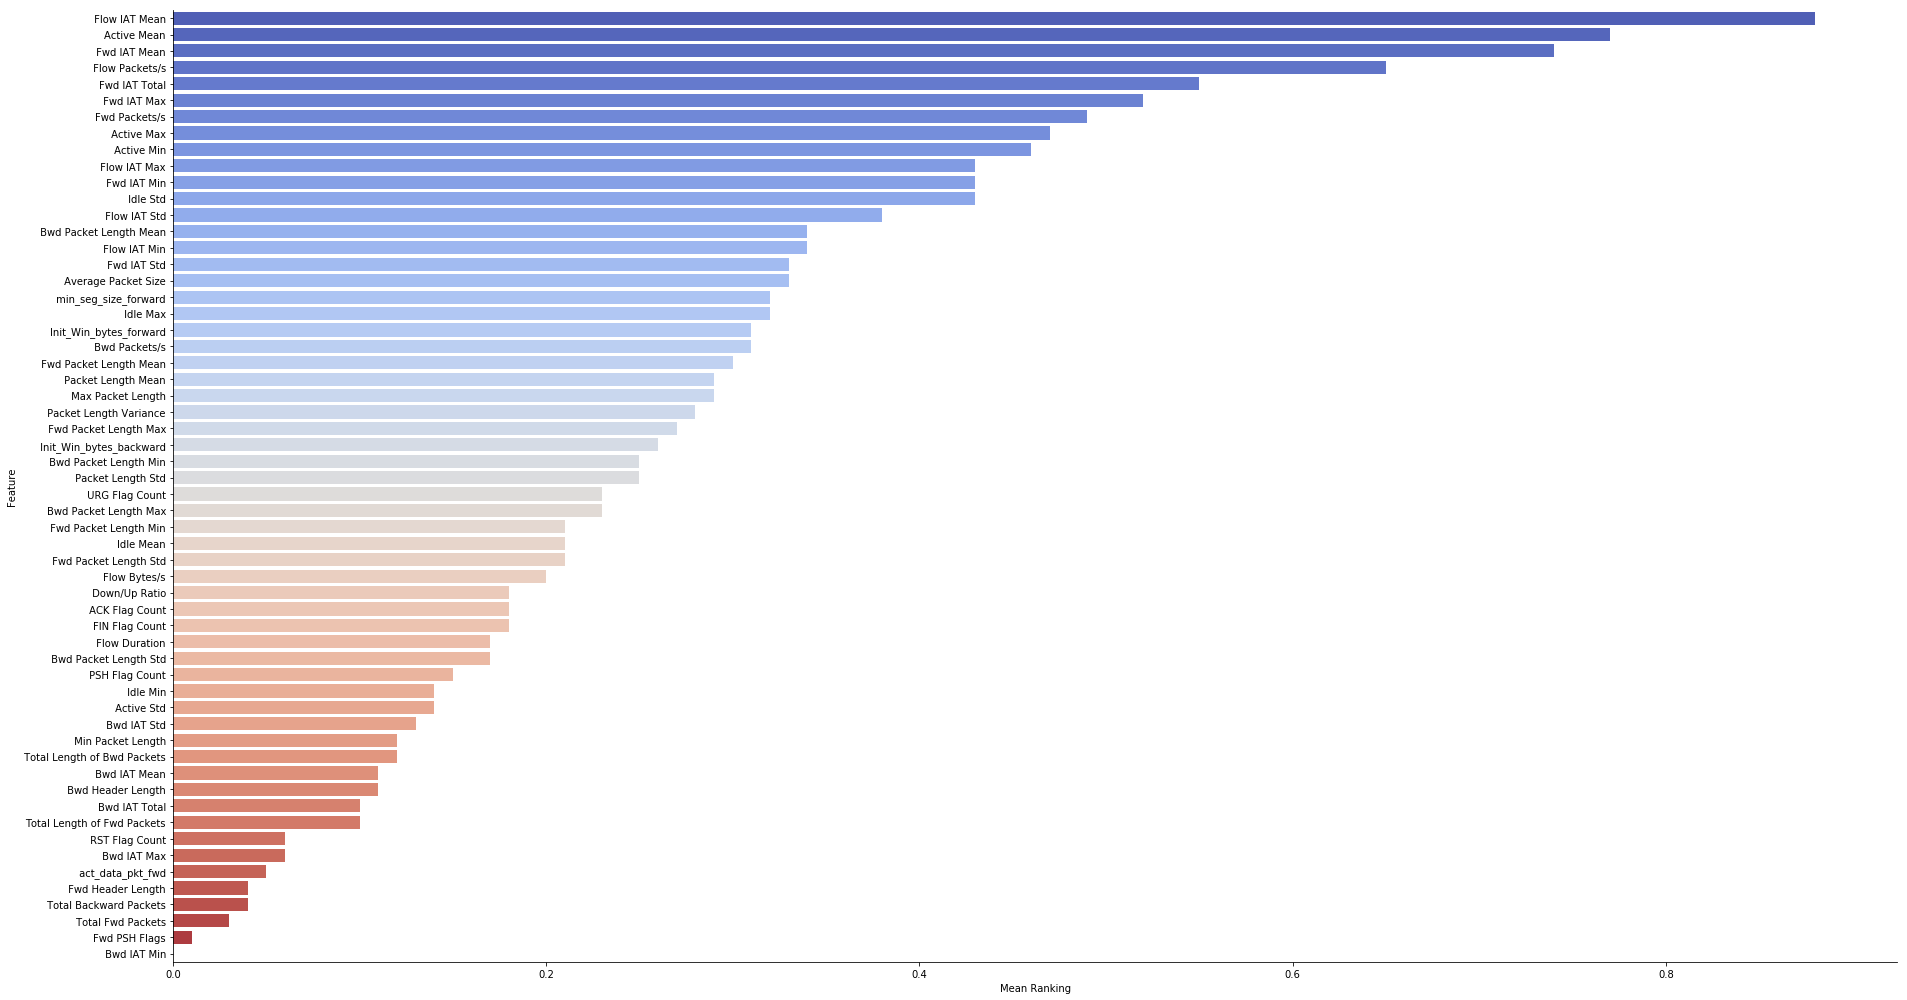

In [49]:
meanplot = pd.DataFrame(list(r.items()), columns= ['Feature','Mean Ranking'])
meanplot = meanplot.sort_values('Mean Ranking', ascending=False)
y2k = sns.factorplot(x="Mean Ranking", y="Feature", data = meanplot, kind="bar", 
               size=14, aspect=1.9, palette='coolwarm')
y2k.savefig("mean_ranking_slowtest.png")

In [50]:
meanplot

,Feature,Mean Ranking
35,Flow IAT Mean,0.88
7,Active Mean,0.77
26,Fwd IAT Mean,0.74
9,Flow Packets/s,0.65
12,Fwd IAT Total,0.55
49,Fwd IAT Max,0.52
13,Fwd Packets/s,0.49
22,Active Max,0.47
18,Active Min,0.46
38,Flow IAT Max,0.43


## Testing

### Three highest grid scores were obtained at 8, 14 and 25 features. So we use these

In [51]:
#YOU CAN GENERATE DIFFERENT TRAINING SAMPLES HERE at #here. x_train, y_train is 70% by default. 

In [52]:
mean_scores = meanplot["Feature"].tolist()
mean_scores[:4]


[' Flow IAT Mean', 'Active Mean', ' Fwd IAT Mean', ' Flow Packets/s']

In [53]:
for i in [4]:
    print("\n-------------------------")
    features_selected = mean_scores[:i] 
    print(features_selected)
    x_trial = X_new[features_selected]
    print(x_trial.shape)
    
    #for size in [0.4, 0.5, 0.6]:
    for size in [0.3]:
        training_x, testing_x, training_y, testing_y = generate_data(x_trial, y, size, 42) #here
        #print(training_y.value_counts())
        clf_rf_2 = RandomForestClassifier()      
        clr_rf_2 = clf_rf_2.fit(training_x, training_y)
        ac_2 = accuracy_score(testing_y, clf_rf_2.predict(testing_x))
        ac_3 = classification_report(testing_y, clf_rf_2.predict(testing_x))
        print("Accuracy at " + str(size) + " for " + str(i) + " is: ", ac_2)
        print(ac_3)


-------------------------
[' Flow IAT Mean', 'Active Mean', ' Fwd IAT Mean', ' Flow Packets/s']
(32448, 4)
Accuracy at 0.3 for 4 is:  0.99301489470981
             precision    recall  f1-score   support

          0       0.99      1.00      1.00      8140
          1       0.98      0.97      0.98      1595

avg / total       0.99      0.99      0.99      9735



### RFE

In [54]:
for i in [4]:
    print("\n-------------------------------------------------------")
    random_forest = RandomForestClassifier()      
    rfe = RFE(estimator=random_forest, n_features_to_select=i, step=1)
    rfe = rfe.fit(x_train, y_train)
    print("RFE features at size " + str(i) + " are \n\n")
    #here
    for el in X_new.columns[rfe.support_]:
        print(el.lstrip())
    
    #for size in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    for size in [0.3]:
        training_x, testing_x, training_y, testing_y = generate_data(X_new, y, size, 42) #train classifier on x%
        training_x = rfe.transform(training_x)
        testing_x = rfe.transform(testing_x)
        print(training_y.value_counts())
        print(training_x.shape)

        clf_rf_2 = RandomForestClassifier()      
        clr_rf_2 = clf_rf_2.fit(training_x, training_y)
        ac_2 = accuracy_score(testing_y, clf_rf_2.predict(testing_x))
        ac_3 = classification_report(testing_y, clf_rf_2.predict(testing_x))
        print("Accuracy at " + str(size) + " for " + str(i) + " is: ", ac_2)
        print(ac_3)

    


-------------------------------------------------------
RFE features at size 4 are 


Flow IAT Mean
Fwd IAT Max
Fwd IAT Min
Init_Win_bytes_forward
0    18937
1     3776
Name: Target, dtype: int64
(22713, 4)
Accuracy at 0.3 for 4 is:  0.9972265023112481
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      8140
          1       0.99      0.99      0.99      1595

avg / total       1.00      1.00      1.00      9735



### K Best

In [55]:
for i in [4]:
    print("\n-----------------------------------------")
    select_feature = SelectKBest(f_classif, k=i).fit(x_train, y_train)
    print("Top " + str(i) + " features :", X_new.columns[select_feature.get_support(indices=True)])
    
    #for size in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    for size in [0.3]:
        training_x, testing_x, training_y, testing_y = generate_data(X_new, y, size, 42) #train classifier on 70%
    
        training_x = select_feature.transform(training_x)
        testing_x = select_feature.transform(testing_x)
        print(training_y.value_counts())
        print(training_x.shape)
    
        clf_rf_2 = RandomForestClassifier()      
        clr_rf_2 = clf_rf_2.fit(training_x, training_y)
        ac_2 = accuracy_score(testing_y, clf_rf_2.predict(testing_x))
        ac_3 = classification_report(testing_y, clf_rf_2.predict(testing_x))
        print("Accuracy at " + str(size) + " for " + str(i) + " is: ", ac_2)
        print(ac_3)



-----------------------------------------
Top 4 features : Index([u' Flow IAT Mean', u'Active Mean', u' Active Min', u' Idle Std'], dtype='object')
0    18937
1     3776
Name: Target, dtype: int64
(22713, 4)
Accuracy at 0.3 for 4 is:  0.9752439650744735
             precision    recall  f1-score   support

          0       0.98      0.99      0.99      8140
          1       0.93      0.92      0.92      1595

avg / total       0.98      0.98      0.98      9735



### Tree based

In [56]:
for i in [4]:
    print("\n-------------------------")
    features_selected = ranking_tree_based[:i] 
    print(features_selected)
    x_trial = X_new[features_selected]
    print(x_trial.shape)
    
    #for size in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    for size in [0.3]:
        training_x, testing_x, training_y, testing_y = generate_data(x_trial, y, size, 42) #here
        #print(training_y.value_counts())
        clf_rf_2 = RandomForestClassifier()      
        clr_rf_2 = clf_rf_2.fit(training_x, training_y)
        ac_2 = accuracy_score(testing_y, clf_rf_2.predict(testing_x))
        ac_3 = classification_report(testing_y, clf_rf_2.predict(testing_x))
        print("Accuracy at " + str(size) + " for " + str(i) + " is: ", ac_2)
        print(ac_3)



-------------------------
[' Fwd IAT Mean', ' Flow Packets/s', 'Active Mean', ' Flow IAT Mean']
(32448, 4)
Accuracy at 0.3 for 4 is:  0.9929121725731895
             precision    recall  f1-score   support

          0       0.99      1.00      1.00      8140
          1       0.98      0.97      0.98      1595

avg / total       0.99      0.99      0.99      9735

